# Topic Analysis
In this notebook I use negative review predictions from the modeling stage to perform topic analysis and identify keywords for the negative reviews. I will the text ranker **`networkx`** to carry out this analysis. Also, I will use a word cloud to visualize the main topics in the reviews.

## Setup

In [0]:
from google.colab import drive
from importlib.machinery import SourceFileLoader
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from wordcloud import WordCloud

%matplotlib inline

Mount Google Drive.

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/Thinkful/Final_Capstone_Project/'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [0]:
# drive.mount(ROOT)

Load custom methods and constants.

In [5]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Load Data
Load the review text for reviews classified as negative.

In [0]:
df_negative = pd.read_csv(os.path.join(PROJECT_PATH, 'data/negative_review_predictions.csv'))

In [7]:
df_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 2 columns):
text      622 non-null object
labels    622 non-null int64
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


## Data Preparation
There are a few data preparation steps that need to be taken before performing topic analysis. I will first tokenize the reviews. Then, I will tag the parts-of-speech for each token. During the modeling stage, I will explore how parts-of-speech affect the prediction of topics relavent to negative reviews.

In [0]:
# Load Spacy's toolset
nlp = spacy.load("en_core_web_sm")

In [0]:
df_negative['tokens'] = df_negative['text'].apply(lambda x: [y.text for y in nlp(x)])

In [10]:
df_negative.loc[:5, 'tokens']

0    [eat, T, maybe, time, enjoy, old, school, fami...
1    [stop, place, avocado, shake, people, smoke, s...
2    [come, eat, usually, service, ok, tonight, dif...
3    [way, price, Door, Dash, order, mushroom, blac...
4    [night, new, city, choose, hostess, ask, sit, ...
5    [honestly, feel, area, maybe, cause, come, rai...
Name: tokens, dtype: object

Combine all reviews together into a single list, which will be the corpus of text.

In [0]:
corpus = []
for review in df_negative['tokens'].values:
  corpus += review

In [12]:
print(f'The corpus of negative reviews contains {len(corpus)} words.')

The corpus of negative reviews contains 33678 words.


Create a list of only the unique words, which will be the vocabulary.

In [0]:
vocab = list(set(corpus))

In [14]:
print(f'The corpus vocabulary size is {len(vocab)} words.')

The corpus vocabulary size is 4971 words.


In [15]:
df_negative['text'].values[:5]

array(['eat T maybe time enjoy old school family setting photo pasta sausage actually meet owner Mobil Headlamp restoration business go house restore car lense find owner go family entail inhale plate linguini clam white sauce go pizza daughter ravioli Mrs come recently week chat Al s bit slurp red sauce spaghetti return open surprise envelope grace patron week italian joy run extra mile week thank Al yah soon',
       'stop place avocado shake people smoke smoke sign say smoke girl friendly sit hour drink shake come fill ice tea bathroom dirty use piece paper open door',
       'come eat usually service ok tonight different story waiter wait half hour tell majority order cook waiter audacity ask want cancel order poor kid starve point upset course cancel order go restaurant close buy kid food terrible customer service experience poor service restaurant say lot eat waiter check wave little thing fork vegetable etc wait remind surprised service bad owner present have dinner friend table

### Parts-of-Speech
Tag the parts-of-speech for each negative review.

In [0]:
df_negative['POS'] = df_negative['text'].apply(lambda x: [y.pos_ for y in nlp(x)])

In [17]:
df_negative.head()

,text,labels,tokens,POS
0,eat T maybe time enjoy old school family setti...,1,"[eat, T, maybe, time, enjoy, old, school, fami...","[VERB, PROPN, ADV, NOUN, VERB, ADJ, NOUN, NOUN..."
1,stop place avocado shake people smoke smoke si...,1,"[stop, place, avocado, shake, people, smoke, s...","[VERB, NOUN, NOUN, VERB, NOUN, VERB, NOUN, NOU..."
2,come eat usually service ok tonight different ...,1,"[come, eat, usually, service, ok, tonight, dif...","[VERB, VERB, ADV, NOUN, INTJ, NOUN, ADJ, NOUN,..."
3,way price Door Dash order mushroom black Romai...,1,"[way, price, Door, Dash, order, mushroom, blac...","[NOUN, NOUN, PROPN, PROPN, NOUN, NOUN, ADJ, PR..."
4,night new city choose hostess ask sit note lit...,1,"[night, new, city, choose, hostess, ask, sit, ...","[NOUN, ADJ, NOUN, VERB, NOUN, VERB, NOUN, VERB..."


When searching for relavent words, I will try filtering the text in a few different ways.

#### Exclude adjectives
First, I will remove all adjectives from the reviews, keeping the rest of the text.

In [0]:
def filter_adjectives(tokens, pos):
  filtered = []
  for x, y in zip(tokens, pos):
    if y != 'ADJ':
      filtered.append(x)
  return ' '.join(filtered)

In [0]:
df_negative['no_adjectives'] = df_negative.apply(lambda x: filter_adjectives(x['tokens'], x['POS']), axis=1)

In [20]:
df_negative['no_adjectives'].values[:5]

array(['eat T maybe time enjoy school family setting photo pasta sausage actually meet owner Mobil Headlamp restoration business go house restore car lense find owner go family entail inhale plate clam sauce go pizza daughter ravioli Mrs come recently week chat Al s bit sauce spaghetti return surprise envelope grace patron week joy run mile week thank Al yah soon',
       'stop place avocado shake people smoke smoke sign say smoke girl sit hour drink shake come fill ice tea bathroom use piece paper door',
       'come eat usually service ok tonight story waiter wait hour tell majority order cook waiter audacity ask want cancel order kid starve point upset course cancel order go restaurant buy food customer service experience service restaurant say lot eat waiter check wave thing fork vegetable etc wait remind service owner present have dinner friend table away service experience tonight lack thereof return',
       'way price Door Dash order mushroom Romaine lettuce rib portion lettuce

Next, I will only keep the nouns, removing all other words from the reviews.

In [0]:
def only_nouns(tokens, pos):
  filtered = []
  for x, y in zip(tokens, pos):
    if y == 'NOUN':
      filtered.append(x)
  return ' '.join(filtered)

In [0]:
df_negative['only_nouns'] = df_negative.apply(lambda x: only_nouns(x['tokens'], x['POS']), axis=1)

In [23]:
df_negative['only_nouns'].values[:5]

array(['time school family photo pasta sausage owner restoration business house car lense owner family entail inhale plate clam sauce pizza daughter ravioli week sauce spaghetti surprise envelope grace patron week joy mile week',
       'place avocado people smoke sign smoke girl sit hour drink shake fill ice tea bathroom use piece paper door',
       'service tonight story waiter hour majority order cook waiter audacity want order kid starve point upset course order restaurant food customer service experience service restaurant lot waiter check thing fork vegetable remind service owner present dinner friend table service experience tonight lack return',
       'way price order mushroom lettuce rib portion lettuce',
       'night city hostess sit minute check list shock return'],
      dtype=object)

## Relevant Words
I will convert the text into TF-IDF vectors. This will allow me to define cutoffs at document frequency to exclude words that are used more commonly.

Before defining a cutoff, let's look at a distribution in inverse document frequency.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['text'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['text'].values)
encodings = vectorizer.transform(df_negative['text'].values)

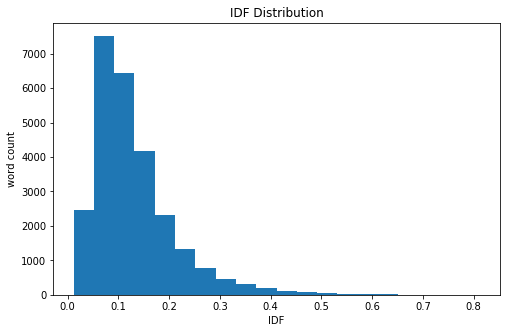

In [25]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution.png'))
plt.show()

Now, I will define a document frequency cutoff of 0.1. This means I will exclude words that are used more than 10% of the time.

In [0]:
vectorizer = TfidfVectorizer(max_df=0.1)
vectorizer.fit(df_negative['text'].values)
idf = vectorizer.idf_
stop_words = vectorizer.stop_words_
vectorizer.fit(df_negative['text'].values)
encodings = vectorizer.transform(df_negative['text'].values)

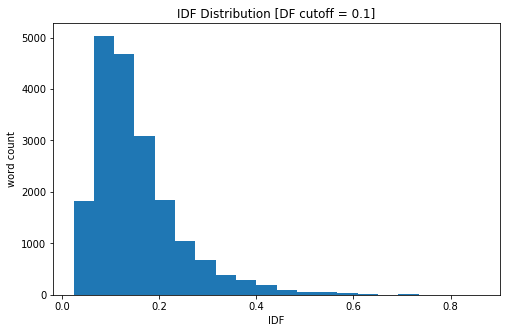

In [27]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [DF cutoff = 0.1]')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution_df_cutoff_01.png'))
plt.show()

### Predict Topics
Gather the vocabulary into a list.

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [29]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 4391 words.


In [30]:
print(f'The first few words of the vocabular are: {vocab[:5]}')

The first few words of the vocabular are: ['maybe', 'enjoy', 'old', 'school', 'family']


#### Adjacency
For each word in the corpus, keep track of that word and the neighbors around it.

In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

Remove corpus-specific stop words.

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [33]:
print(f'The corpus size is now {len(corpus_clean)} words.')

The corpus size is now 23348 words.


In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
      df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

#### Text Rank
Calculate TextRank using networkx.

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)

In [0]:
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [40]:
df_rankings.head(n=10)

,rank,word
0,0.003158,dish
1,0.003020,friend
2,0.002746,water
3,0.002720,quality
4,0.002714,waiter
5,0.002682,seat
6,0.002567,pizza
7,0.002532,bring
8,0.002531,bar
9,0.002442,salad


These words appear to vague. They don't point out specific areas where a restaurant could improve.

### No Adjectives
Repeat the analysis as above, but now remove all of the adjectives.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['no_adjectives'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['no_adjectives'].values)
encodings = vectorizer.transform(df_negative['no_adjectives'].values)

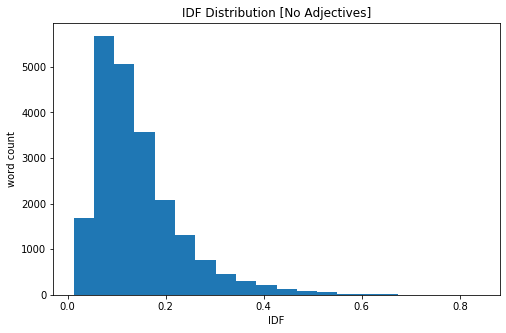

In [42]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [No Adjectives]')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution_no_adjectives.png'))
plt.show()

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [44]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 3754 words.


In [45]:
print(f'The first few words of the vocabular are: {vocab[:5]}')

The first few words of the vocabular are: ['eat', 'maybe', 'time', 'enjoy', 'school']


In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [48]:
print(f'The corpus size is now {len(corpus_clean)} words.')

The corpus size is now 31267 words.


In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
    df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [54]:
df_rankings.head(n=10)

,rank,word
0,0.012417,order
1,0.012172,food
2,0.010396,come
3,0.009300,place
4,0.008014,like
5,0.007488,good
6,0.007444,time
7,0.006112,service
8,0.006095,ask
9,0.005629,restaurant


Better! These words seem to point more to things, like 'food' and 'place', which refer to specific areas of restaurant improvement. But, the word 'come' does not add much meaning.

Since I am interested in just things, let's try only including nouns.

### Only Nouns
Only use nouns seen in the corpus of negative review text.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['only_nouns'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['only_nouns'].values)
encodings = vectorizer.transform(df_negative['only_nouns'].values)

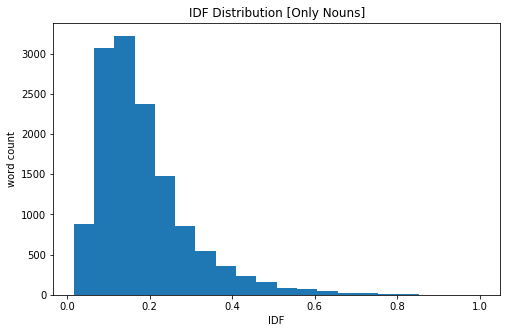

In [56]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [Only Nouns]')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution_only_nouns.png'))
plt.show()

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [58]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 2507 words.


In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
    df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [66]:
df_rankings.head(n=10)

,rank,word
0,0.015447,order
1,0.015330,food
2,0.013221,come
3,0.011927,place
4,0.009191,time
5,0.007684,ask
6,0.007664,service
7,0.007030,go
8,0.006961,restaurant
9,0.006043,eat


Excellent! Now, I have specific things that customers are complaining about. 

Let's explore topic further by generating a few visualizations.

## Bar Plot
I will ranks in a bar plot to display the relative importance between different words. To make plot more pleasing, I will normalize the ranks between 0 and 1.

In [0]:
min_rank = df_rankings['rank'].min()
rank_range = df_rankings['rank'].max() - df_rankings['rank'].min()
df_rankings['norm_rank'] = (df_rankings['rank'] - min_rank) / rank_range

In [68]:
df_rankings.head(n=10)

,rank,word,norm_rank
0,0.015447,order,1.000000
1,0.015330,food,0.992397
2,0.013221,come,0.855086
3,0.011927,place,0.770842
4,0.009191,time,0.592744
5,0.007684,ask,0.494681
6,0.007664,service,0.493360
7,0.007030,go,0.452131
8,0.006961,restaurant,0.447635
9,0.006043,eat,0.387881


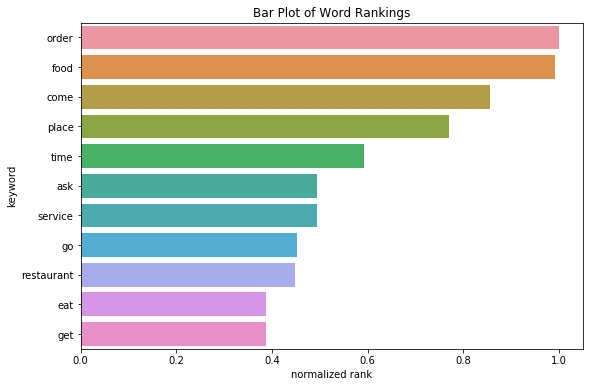

In [69]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(x='norm_rank', y='word', data=df_rankings.loc[:10,:], ax=ax)
ax.set_xlabel('normalized rank')
ax.set_ylabel('keyword')
ax.set_title('Bar Plot of Word Rankings')
plt.savefig(os.path.join(PROJECT_PATH, 'images/word_rankings_bar_plot.png'))
plt.show()

## Word Cloud
Another way to visualize the importance of words is creating a word cloud. The size of each word in the below image is related to how much that word is used in the corpus.

In [0]:
corpus_string = ' '.join(corpus_clean)

In [0]:
word_cloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_string)

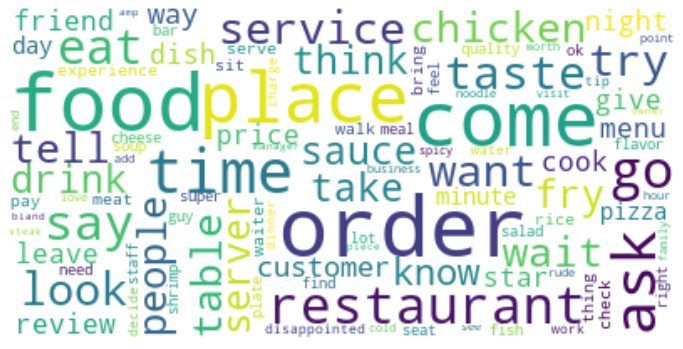

In [72]:
plt.figure(figsize=(12, 7))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(os.path.join(PROJECT_PATH, 'images/word_cloud.png'))
plt.show()

## Summary and Conclusions
This project addressed the question: _How can restaurants be successful in the South Bay?_ I used review data scrapped from Yelp. Then I performed sentiment analysis, using the ratings as labels and the review text as features. The ratings were split into two groups, positive (4-5 stars) and negative (1-2 stars). I tried four different models and concluded that a simple, multi-layer perceptron model performed the best. The negative review predictions for this model were passed on to the topic analysis phase, where I search for trends in the text that related to areas of improvement for restaurants.

I found that the five main areas of improvement are: **food**, **order**, **place**, **service**, and **time**. Food and order imply problems related to the quality of the food. Service and time, seem related to the customer experience. Place could indicate complaints about the ambiance or decour.